# 3D Metrology


* Train Dataset (학습용 데이터셋, 학습 가능) - 총 60664개
SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상)
average_depth.csv : 전체 SEM 영상과 대응되는 평균 Depth


* Simulation Dataset (학습용 데이터셋, 학습 가능) - 총 259956개
  * SEM [폴더] : Simulator을 통해 생성한 Hole 단위 SEM 영상 (실제 SEM 영상과 유사하나, 대응 관계는 없음)
  * Depth [폴더] : Simulator을 통해 얻은 SEM 영상과 Pixel별로 대응되는 Depth Map
Depth 이미지 1개당 2개의 Simulator Hole 단위 SEM 영상이 Pair하게 매칭됩니다. (Name_itr0, Name_itr1)


* Test Dataset (평가를 위한 테스트 데이터셋, 학습 불가능) - 총 25998개
SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상)


* sample_submission.zip (제출 양식) - 총 25998개
실제 Hole 단위 SEM 영상으로부터 추론한 Depth Map (.png, int)

## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')
 
from google.colab.patches import cv2_imshow

from torchvision import transforms # 데이터 증강을 위한 transform

import PIL # 이미지


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')               #구글 코랩환경으로 실험 진행

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/공유 드라이브/삼성데이콘/open.zip"    # 구글 드라이브에 있는 데이터 알집을 풀고 실험 진행

## Hyperparameter Setting

In [ ]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## K-Fold 방식의 데이터 분할

원래 주어졌던 Baseline의 코드의 경우 HoldOut 방식으로 진행되었는데,
Simulation SEM 영상과 대응되는 Depth map 폴더를 보니 각 폴더별로 파일 수가 달라 그렇게 진행했을 때 성능에 영향을 줄 것이라고 판단해서 각 서브폴더별로 일정 비율의 갯수를 가져오게 코드를 수정

In [ ]:
## sem 비율 적당히 해서 쪼개기

# case 1 
sim_sem_c1_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/80/*.png'))
sim_sem_c1_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/81/*.png'))
sim_sem_c1_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/82/*.png'))
sim_sem_c1_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/83/*.png'))
sim_sem_c1_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/84/*.png'))

# case 2
sim_sem_c2_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/80/*.png'))
sim_sem_c2_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/81/*.png'))
sim_sem_c2_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/82/*.png'))
sim_sem_c2_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/83/*.png'))
sim_sem_c2_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/84/*.png'))

# case 3
sim_sem_c3_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/80/*.png'))
sim_sem_c3_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/81/*.png'))
sim_sem_c3_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/82/*.png'))
sim_sem_c3_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/83/*.png'))
sim_sem_c3_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/84/*.png'))

# case 4
sim_sem_c4_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/80/*.png'))
sim_sem_c4_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/81/*.png'))
sim_sem_c4_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/82/*.png'))
sim_sem_c4_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/83/*.png'))
sim_sem_c4_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/84/*.png'))

## depth 비율 적당히 해서 쪼개기

# case 1
sim_depth_c1_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/80/*.png') + glob.glob('./simulation_data/Depth/Case_1/80/*.png'))
sim_depth_c1_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/81/*.png') + glob.glob('./simulation_data/Depth/Case_1/81/*.png'))
sim_depth_c1_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/82/*.png') + glob.glob('./simulation_data/Depth/Case_1/82/*.png'))
sim_depth_c1_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/83/*.png') + glob.glob('./simulation_data/Depth/Case_1/83/*.png'))
sim_depth_c1_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/84/*.png') + glob.glob('./simulation_data/Depth/Case_1/84/*.png'))

# case 2
sim_depth_c2_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/80/*.png') + glob.glob('./simulation_data/Depth/Case_2/80/*.png'))
sim_depth_c2_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/81/*.png') + glob.glob('./simulation_data/Depth/Case_2/81/*.png'))
sim_depth_c2_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/82/*.png') + glob.glob('./simulation_data/Depth/Case_2/82/*.png'))
sim_depth_c2_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/83/*.png') + glob.glob('./simulation_data/Depth/Case_2/83/*.png'))
sim_depth_c2_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/84/*.png') + glob.glob('./simulation_data/Depth/Case_2/84/*.png'))

# case 3
sim_depth_c3_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/80/*.png') + glob.glob('./simulation_data/Depth/Case_3/80/*.png'))
sim_depth_c3_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/81/*.png') + glob.glob('./simulation_data/Depth/Case_3/81/*.png'))
sim_depth_c3_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/82/*.png') + glob.glob('./simulation_data/Depth/Case_3/82/*.png'))
sim_depth_c3_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/83/*.png') + glob.glob('./simulation_data/Depth/Case_3/83/*.png'))
sim_depth_c3_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/84/*.png') + glob.glob('./simulation_data/Depth/Case_3/84/*.png'))

# case 4
sim_depth_c4_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/80/*.png') + glob.glob('./simulation_data/Depth/Case_4/80/*.png'))
sim_depth_c4_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/81/*.png') + glob.glob('./simulation_data/Depth/Case_4/81/*.png'))
sim_depth_c4_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/82/*.png') + glob.glob('./simulation_data/Depth/Case_4/82/*.png'))
sim_depth_c4_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/83/*.png') + glob.glob('./simulation_data/Depth/Case_4/83/*.png'))
sim_depth_c4_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/84/*.png') + glob.glob('./simulation_data/Depth/Case_4/84/*.png'))

In [ ]:
# 각 case의 서브폴더(80,81,82,83) 안의 길이 확인
 
len_80 = len(sim_sem_c1_80_paths)
len_81 = len(sim_sem_c1_81_paths)
len_82 = len(sim_sem_c1_82_paths)
len_83 = len(sim_sem_c1_83_paths)
len_84 = len(sim_sem_c2_84_paths)

In [ ]:
# 이용하고 싶은 data 비율 정하기
ratio = 1

In [ ]:
# validation 자르고 싶은 비율 정하기
v_ratio = 0.2

In [ ]:
# train sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc1_81 = sim_sem_c1_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc1_82 = sim_sem_c1_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc1_83 = sim_sem_c1_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc1_84 = sim_sem_c1_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc2_81 = sim_sem_c2_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc2_82 = sim_sem_c2_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc2_83 = sim_sem_c2_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc2_84 = sim_sem_c2_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc3_81 = sim_sem_c3_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc3_82 = sim_sem_c3_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc3_83 = sim_sem_c3_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc3_84 = sim_sem_c3_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc4_81 = sim_sem_c4_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc4_82 = sim_sem_c4_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc4_83 = sim_sem_c4_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc4_84 = sim_sem_c4_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

tsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# train depth paths 정하기

dvc1_80 = sim_depth_c1_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc1_81 = sim_depth_c1_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc1_82 = sim_depth_c1_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc1_83 = sim_depth_c1_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc1_84 = sim_depth_c1_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc2_81 = sim_depth_c2_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc2_82 = sim_depth_c2_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc2_83 = sim_depth_c2_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc2_84 = sim_depth_c2_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc3_81 = sim_depth_c3_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc3_82 = sim_depth_c3_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc3_83 = sim_depth_c3_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc3_84 = sim_depth_c3_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc4_81 = sim_depth_c4_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc4_82 = sim_depth_c4_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc4_83 = sim_depth_c4_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc4_84 = sim_depth_c4_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

tdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
# valid sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[:int(len_80*v_ratio)]
vc1_81 = sim_sem_c1_81_paths[:int(len_81*v_ratio)]
vc1_82 = sim_sem_c1_82_paths[:int(len_82*v_ratio)]
vc1_83 = sim_sem_c1_83_paths[:int(len_83*v_ratio)]
vc1_84 = sim_sem_c1_84_paths[:int(len_84*v_ratio)]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[:int(len_80*v_ratio)]
vc2_81 = sim_sem_c2_81_paths[:int(len_81*v_ratio)]
vc2_82 = sim_sem_c2_82_paths[:int(len_82*v_ratio)]
vc2_83 = sim_sem_c2_83_paths[:int(len_83*v_ratio)]
vc2_84 = sim_sem_c2_84_paths[:int(len_84*v_ratio)]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[:int(len_80*v_ratio)]
vc3_81 = sim_sem_c3_81_paths[:int(len_81*v_ratio)]
vc3_82 = sim_sem_c3_82_paths[:int(len_82*v_ratio)]
vc3_83 = sim_sem_c3_83_paths[:int(len_83*v_ratio)]
vc3_84 = sim_sem_c3_84_paths[:int(len_84*v_ratio)]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[:int(len_80*v_ratio)]
vc4_81 = sim_sem_c4_81_paths[:int(len_81*v_ratio)]
vc4_82 = sim_sem_c4_82_paths[:int(len_82*v_ratio)]
vc4_83 = sim_sem_c4_83_paths[:int(len_83*v_ratio)]
vc4_84 = sim_sem_c4_84_paths[:int(len_84*v_ratio)]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

vsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# valid depth 길이 정하기

dvc1_80 = sim_depth_c1_80_paths[:int(len_80*v_ratio)]
dvc1_81 = sim_depth_c1_81_paths[:int(len_81*v_ratio)]
dvc1_82 = sim_depth_c1_82_paths[:int(len_82*v_ratio)]
dvc1_83 = sim_depth_c1_83_paths[:int(len_83*v_ratio)]
dvc1_84 = sim_depth_c1_84_paths[:int(len_84*v_ratio)]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[:int(len_80*v_ratio)]
dvc2_81 = sim_depth_c2_81_paths[:int(len_81*v_ratio)]
dvc2_82 = sim_depth_c2_82_paths[:int(len_82*v_ratio)]
dvc2_83 = sim_depth_c2_83_paths[:int(len_83*v_ratio)]
dvc2_84 = sim_depth_c2_84_paths[:int(len_84*v_ratio)]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[:int(len_80*v_ratio)]
dvc3_81 = sim_depth_c3_81_paths[:int(len_81*v_ratio)]
dvc3_82 = sim_depth_c3_82_paths[:int(len_82*v_ratio)]
dvc3_83 = sim_depth_c3_83_paths[:int(len_83*v_ratio)]
dvc3_84 = sim_depth_c3_84_paths[:int(len_84*v_ratio)]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[:int(len_80*v_ratio)]
dvc4_81 = sim_depth_c4_81_paths[:int(len_81*v_ratio)]
dvc4_82 = sim_depth_c4_82_paths[:int(len_82*v_ratio)]
dvc4_83 = sim_depth_c4_83_paths[:int(len_83*v_ratio)]
dvc4_84 = sim_depth_c4_84_paths[:int(len_84*v_ratio)]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

vdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
train_sem_paths = tsvc
train_depth_paths = tdvc

val_sem_paths = vsvc
val_depth_paths = vdvc

In [ ]:
len(train_sem_paths)

138652

## Data Augmentation으로 데이터 증강

In [ ]:
class TransformedDataset(Dataset):              #Transform이 있을경우, SEM영상과 Depth Map에 동일한 Transform을 적용해야 도메인을 유지한 채 학습
    def __init__(self, sem_path_list, depth_path_list, transform = None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = PIL.Image.open(sem_path).convert("L")
        if(self.transform):                                                     # transform 진행
            sem_img = self.transform(sem_img)
        sem_img = np.array(sem_img)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = PIL.Image.open(depth_path).convert("L")
            if(self.transform):                                                 # transform 진행
                depth_img = self.transform(depth_img)
            depth_img = np.array(depth_img)
            depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
            depth_img = depth_img / 255.

            return torch.Tensor(sem_img), torch.Tensor(depth_img)  
          

        else:
            img_name = sem_path.split('/')[-1]                                  
            
            return torch.Tensor(sem_img), img_name                              # B,C,H,W
          
            
    def __len__(self):
        return len(self.sem_path_list)

In [ ]:
# 상하좌우 변환은 모델 학습에 있어서 유의미한 결과를 만들어낼 것이라는 판단에 의해 진행
horizontalTransform = transforms.RandomHorizontalFlip(1.0)
verticalTransform = transforms.RandomVerticalFlip(1.0)
mixTransform = transforms.RandomRotation((180,180))

# jitterTransform의 경우에는 Simulation 과 Train사이의 간극을 줄이기 위해 추가
jitterTransform08 = transforms.ColorJitter(brightness = [0.8,0.8])
jitterTransform09 = transforms.ColorJitter(brightness = [0.9,0.9])



In [ ]:
t_origindataset = TransformedDataset(train_sem_paths, train_depth_paths,None)
t_horizontalTransformeddataset = TransformedDataset(train_sem_paths, train_depth_paths, transform = horizontalTransform)
t_verticalTransformeddataset = TransformedDataset(train_sem_paths, train_depth_paths, transform = verticalTransform)
t_mixdataset = TransformedDataset(train_sem_paths,train_depth_paths, transform = mixTransform)

t_jitter08 = TransformedDataset(train_sem_paths,train_depth_paths, transform = jitterTransform08)
t_jitter09 = TransformedDataset(train_sem_paths,train_depth_paths, transform = jitterTransform09)


train_dataset = t_origindataset + t_horizontalTransformeddataset + t_verticalTransformeddataset + t_mixdataset + t_jitter08 + t_jitter09  # train_dataset : 원본 + 좌우반전 + 상하반전 + 180도회전 + 밝기를 어둡게 jittering

In [ ]:
v_origindataset = TransformedDataset(val_sem_paths, val_depth_paths,None)
v_horizontalTransformeddataset = TransformedDataset(val_sem_paths, val_depth_paths, transform = horizontalTransform)
v_verticalTransformeddataset = TransformedDataset(val_sem_paths, val_depth_paths, transform = verticalTransform)
v_mixdataset = TransformedDataset(val_sem_paths,val_depth_paths, transform = mixTransform)

valid_dataset = v_origindataset + v_horizontalTransformeddataset + v_verticalTransformeddataset + v_mixdataset # valid_dataset : 원본 + 좌우반전 + 상하반전 + 180도회전

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 6)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = False, num_workers = 6) # 지표니까 크게 신경 안써도 됨.

In [ ]:
len(train_dataset), len(valid_dataset)

(831912, 138608)

## New Model Define

### New Model 구조 
기존의 BaseLine Model에서 Convolutional AutoEncoder 형태로 변환

Encoder -> Flatten -> Linear -> UnFlatten -> Decoder 
                   

In [ ]:
class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,64,3, stride=2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,3, stride=2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride=2, padding = 1),
            nn.ReLU()
            )
        
        self.flatten = nn.Sequential(nn.Flatten(start_dim = 1),
                                     nn.Dropout(0.2))

        self.encoder_lin = nn.Sequential(
            nn.Linear(256*9*6,2048),
            nn.ReLU(),
            nn.Linear(2048, 256*9*6),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size = (256,9,6))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding = 1,output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3, stride=2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1,3, stride=2, padding = 1, output_padding = 1)
        )
        
    def forward(self, x):
        x = self.encoder(x)

        x = self.flatten(x)

        x = self.encoder_lin(x)

        x = self.unflatten(x)

        x = self.decoder(x)                                                     # decoder 를 빠져나온 x는 추정된 depth map이 일렬로 쭉 늘어져 있는 것 

        return x

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, epochs, device):       # 해당 모델은 1)img를 생성하는 임무, 2)depth를 실수로 예측하는 임무 
    model.to(device)                                              
    criterion_img = nn.L1Loss().to(device)   
    best_score = 999999
    best_model = None
    best_hist = []
    for epoch in range(1, epochs + 1):                                          # 학습이 진행되는 동안
        model.train()
        train_loss = []                                                         # img + depth 에 대한 loss 리스트 생성
       
        for sem, depth in tqdm(iter(train_loader)):                             # simulation을 이용한 train_loader 에는 sem 이미지, depth 이미지, depth 이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            
            optimizer.zero_grad()                                               # 기울기 초기화
            
            model_pred_img = model(sem)                                         # model이 예측한 depth map image
            #print(label.shape, model_pred_label.shape)
            loss_img = criterion_img(model_pred_img, depth)                     # img에 대한 loss 계산
            
            loss_img.backward()                                                 # 역전파

            optimizer.step()                                                    
            

            train_loss.append(loss_img.item())                            
            
        
        val_img_loss, val_img_rmse = validation(model, criterion_img,val_loader, device) # 검증 진행
        
        print(f'Epoch : [{epoch}] Train Total Loss : [{np.mean(train_loss):.5f}] Val img Loss : [{val_img_loss:.5f}] Val img RMSE : [{val_img_rmse:.5f}]')
        if best_score > val_img_rmse:                                           # rmse가 더 낮다고 판단되면 좋은 모델이라고 생각하고 교체
            best_score = val_img_rmse
            best_model = model
            best_hist = [epoch, np.mean(train_loss), val_img_rmse]
        
        if scheduler is not None:                                               
            scheduler.step()

    print("<<BEST>>")                                                           # 제일 좋은 모델의 값들 출력
    print(f"Epoch : {best_hist[0]} / Train Loss : {best_hist[1]:.5f} / Val Loss : {best_hist[2]:.5f} / Val RMSE : {best_score}")      
    
    
    return best_model

In [ ]:
def validation(model, criterion_img, val_loader, device):                       # 검증 
    model.eval()                                                                # img에 대한 loss
    b_rmse_img = nn.MSELoss().to(device)                                        # img에 대한 rmse 설정
    
    val_img_loss = []                                                           # 값을 담아놓을 리스트들 선언
    val_img_rmse = []

    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, depth in tqdm(iter(val_loader)):                               # val_loader 또한 sem이미지, depth이미지, depth이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            
            model_pred_img = model(sem)                                         # model이 예측한 depth map 임
            loss_img = criterion_img(model_pred_img, depth)                     # depth map에 대한 loss 계산
            # image 
            pred = (model_pred_img*255.).type(torch.int8).float()               # 예측 depth 이미지
            true = (depth*255.).type(torch.int8).float()                        # 실제 depth 이미지

            b_rmse_img = torch.sqrt(criterion_img(pred, true))                  # 두 값의 rmse

            
            val_img_loss.append(loss_img.item())                                # 각각의 loss, rmse 리스트에 추가하기
            val_img_rmse.append(b_rmse_img.item())

            # Total
            total_loss = loss_img
            b_rmse_total = torch.sqrt((total_loss))

    return np.mean(val_img_loss), np.mean(val_img_rmse)

## Run!!

In [ ]:
model = NewModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)   # learning rate scheduler
                                                                                                    # epoch가 늘어날수록 learning rate 점점 작아지도록 함

infer_model = train(model, optimizer, train_loader, valid_loader, scheduler, CFG['EPOCHS'], device)

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [1] Train Total Loss : [0.01742] Val img Loss : [0.01974] Val img RMSE : [2.63376]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [2] Train Total Loss : [0.01052] Val img Loss : [0.00965] Val img RMSE : [1.98061]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [3] Train Total Loss : [0.00862] Val img Loss : [0.00786] Val img RMSE : [1.79744]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [4] Train Total Loss : [0.00755] Val img Loss : [0.00625] Val img RMSE : [1.72189]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [5] Train Total Loss : [0.00685] Val img Loss : [0.00650] Val img RMSE : [1.79281]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [6] Train Total Loss : [0.00640] Val img Loss : [0.00580] Val img RMSE : [1.65240]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [7] Train Total Loss : [0.00601] Val img Loss : [0.00599] Val img RMSE : [1.58888]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [8] Train Total Loss : [0.00579] Val img Loss : [0.00560] Val img RMSE : [1.69738]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [9] Train Total Loss : [0.00556] Val img Loss : [0.00528] Val img RMSE : [1.61970]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [10] Train Total Loss : [0.00537] Val img Loss : [0.00523] Val img RMSE : [1.64999]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [11] Train Total Loss : [0.00522] Val img Loss : [0.00555] Val img RMSE : [1.54445]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [12] Train Total Loss : [0.00509] Val img Loss : [0.00513] Val img RMSE : [1.61909]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [13] Train Total Loss : [0.00497] Val img Loss : [0.00515] Val img RMSE : [1.66284]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [14] Train Total Loss : [0.00488] Val img Loss : [0.00544] Val img RMSE : [1.51981]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [15] Train Total Loss : [0.00478] Val img Loss : [0.00522] Val img RMSE : [1.66928]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [16] Train Total Loss : [0.00469] Val img Loss : [0.00518] Val img RMSE : [1.56262]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [17] Train Total Loss : [0.00460] Val img Loss : [0.00492] Val img RMSE : [1.64221]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [18] Train Total Loss : [0.00453] Val img Loss : [0.00499] Val img RMSE : [1.63524]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [19] Train Total Loss : [0.00445] Val img Loss : [0.00489] Val img RMSE : [1.56591]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]

Epoch : [20] Train Total Loss : [0.00438] Val img Loss : [0.00490] Val img RMSE : [1.56084]
<<BEST>>
Epoch : 14 / Train Loss : 0.00488 / Val Loss : 1.51981 / Val RMSE : 1.5198139798718255


In [ ]:
model1 = torch.save(infer_model,'/content/drive/MyDrive/bestmodel.pt') # 모델 저장

## Inference & Submission
### 후처리 진행 
#### 배경의 중앙값 기준으로 일의 자리에서 반올림한 값으로 배경 픽셀값 통일 

In [ ]:
infer_model = torch.load('/content/drive/MyDrive/bestmodel.pt')

In [ ]:
add_train_paths = sorted(glob.glob('/content/train/SEM/*/*/*.png'))

In [ ]:
add_train_dataset = TransformedDataset(add_train_paths,None)
add_train_loader = DataLoader(add_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = False, num_workers = 6)

In [ ]:
import zipfile
def inference(model, test_loader, device):  
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, name in tqdm(iter(test_loader)):                               # test data에는 sem 영상만 있음, train으로 train_to_depth 만들때도 마찬가지
            sem = sem.float().to(device)
            model_pred_img = model(sem)                                         # 예측된 depth map 이미지와 depth 값
            
            for pred, img_name in zip(model_pred_img, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.
                pred = pred.astype(int)
                
                Min_value = np.min(pred[0])                                     # 첫째 줄에서 가장 작은 값
                sorted_arr = np.sort(pred[0]) 
                Median_value = sorted_arr[23]                                   # 첫째 줄에서 중앙값
                Class = np.round(Median_value,-1)                               # 값이 140,150,160,170으로 떨어지도록 반올림
                pred[pred>=Min_value] = Class                                   
                pred[pred>Class] = Class                                        # 바깥부분이 모두 140,150,160,170으로 나오게 수정
                save_img_path = f'{img_name}'
                result_name_list.append(save_img_path)
                result_list.append(pred)                                        # 이미지 저장
    
    os.makedirs('/content/ttd', exist_ok=True)
    os.chdir("/content/ttd/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/content/train_to_depth.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close() 

In [ ]:
cd /content/

/content


In [ ]:
inference(infer_model, add_train_loader, device) # train 영상과 기존의 모델로 생성된 데이터 확인 -> 로컬에 저장됨.

  0%|          | 0/474 [00:00<?, ?it/s]

## ====================================================

### Model에 Train SEM 넣어 나온 Train to Depth 파일 관찰 

In [ ]:
train_to_depth_paths = sorted(glob.glob('/content/ttd/*.png')) 
idx = 0
M = 0
cnt130=0
cnt140=0
cnt150=0
cnt160=0
cnt170=0
for i in train_to_depth_paths:
  #if(idx%1000==0):
  img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
  #cv2_imshow(img)
  m = np.max(img)
  if(m==130):
    #print(m)
    cnt130+=1
  elif(m==140):
    cnt140+=1
  elif(m==150):
    cnt150+=1
  elif(m==160):
    cnt160+=1
  elif(m>=170):
    cnt170+=1
  #cv2_imshow(img)
  #print(np.max(img) - np.min(img))
  idx+=1
print('cnt130 : ',cnt130)
print('cnt140 : ',cnt140)
print('cnt150 : ',cnt150)
print('cnt160 : ',cnt160)
print('cnt170 : ',cnt170)
print(idx)

cnt130 :  0
cnt140 :  15556
cnt150 :  14954
cnt160 :  15766
cnt170 :  14388
60664


## 기존의 저장된 모델 불러와서, train과 avg_depth 정보 이용해서 추가학습

In [ ]:
Model = torch.load('/content/drive/MyDrive/bestmodel.pt') # 모델 불러오기

## train_to_depth 폴더 안으로 파일 집어넣기

In [ ]:
os.mkdir("/content/train_to_depth")

In [ ]:
cd /content/train_to_depth/

/content/train_to_depth


In [ ]:
!unzip -qq '/content/train_to_depth.zip' # 로컬에 저장되어있을 simulation data를 이용한 모델로 새로 생성한 train이미지에 대응되는 생성이미지

In [ ]:
cd /content

/content


## train_to_depth 이미지가 잘 나오나 확인

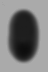

157


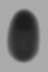

141


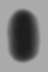

141


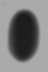

144


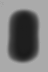

144


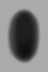

157


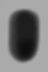

158


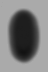

152


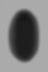

148


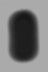

148


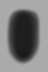

145


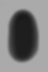

144


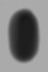

146


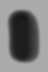

148


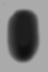

157


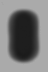

143


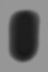

127


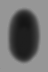

129


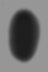

125


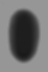

125


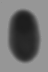

122


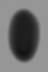

132


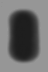

121


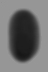

128


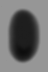

137


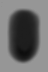

137


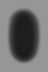

123


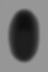

135


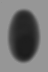

123


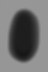

128


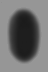

123


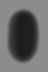

113


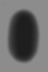

111


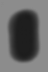

112


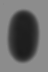

113


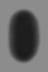

114


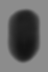

122


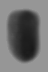

125


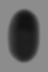

123


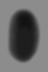

123


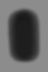

115


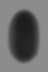

113


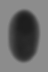

111


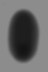

120


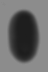

111


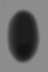

121


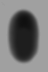

144


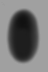

143


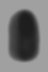

131


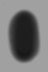

137


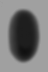

144


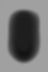

141


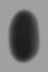

132


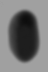

147


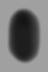

141


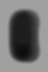

147


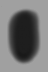

136


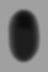

149


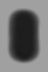

135


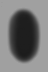

132


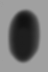

144


In [ ]:
train_to_depth_paths = sorted(glob.glob('/content/train_to_depth/*.png')) # 파일을 1000장마다 한 번씩 출력하기 -> 중간에 이상이 있다면 그냥 추가학습 하지말고 sim data를 잘 학습시켜야 함.
idx = 0
M = 0
for i in train_to_depth_paths:
  if(idx%1000==0):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    cv2_imshow(img)
    print(np.max(img) - np.min(img))
  idx+=1

## train 데이터와 train_to_depth, avg_depth 이용해서 추가학습

In [ ]:
# train-SEM 데이터
sem_paths = sorted(glob.glob('/content/train/SEM/*/*/*.png'), key=lambda x : x[-14:-4])   # 이미지 번호에 맞게 정렬

depth_paths = sorted(glob.glob("/content/train_to_depth/*.png"))

sem_paths[:5], depth_paths[:5]

(['/content/train/SEM/Depth_140/site_00201/SEM_000001.png',
  '/content/train/SEM/Depth_140/site_00413/SEM_000002.png',
  '/content/train/SEM/Depth_140/site_00097/SEM_000005.png',
  '/content/train/SEM/Depth_140/site_00099/SEM_000006.png',
  '/content/train/SEM/Depth_140/site_00475/SEM_000008.png'],
 ['/content/train_to_depth/SEM_000001.png',
  '/content/train_to_depth/SEM_000002.png',
  '/content/train_to_depth/SEM_000005.png',
  '/content/train_to_depth/SEM_000006.png',
  '/content/train_to_depth/SEM_000008.png'])

### 추가학습의 경우에는 Simulation SEM 영상을 학습할 때와 다르게 HoldOut 방식 적용

In [ ]:
# train : val = 8 : 2
add_train_sem_paths = sem_paths[:int(len(sem_paths)*0.8)]
add_val_sem_paths = sem_paths[int(len(sem_paths)*0.8):]

add_train_depth_paths = depth_paths[:int(len(sem_paths)*0.8)]
add_val_depth_paths = depth_paths[int(len(sem_paths)*0.8):]

In [ ]:
at_origindataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths) 

at_horizontalTransformeddataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, transform = horizontalTransform)
at_verticalTransformeddataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, transform = verticalTransform) 
at_mixdataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, transform = mixTransform) 

add_train_dataset = at_origindataset + at_horizontalTransformeddataset + at_verticalTransformeddataset + at_mixdataset 
# add_train_dataset 생성

In [ ]:
av_origindataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths) 
av_horizontalTransformeddataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, transform = horizontalTransform) 
av_verticalTransformeddataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, transform = verticalTransform) 
av_mixdataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, transform = mixTransform) 

add_valid_dataset = av_origindataset + av_horizontalTransformeddataset + av_verticalTransformeddataset + av_mixdataset 
# add_valid_dataset 생성

In [ ]:
add_train_loader = DataLoader(add_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

add_val_loader = DataLoader(add_valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

### Train 실제 SEM 환경에서의 train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):       # 해당 모델은 1)img를 생성하는 임무, 2)depth를 실수로 예측하는 임무 
    model.to(device)                                              
    criterion_img = nn.L1Loss().to(device)   
                                                                                 # loss를 2가지로 설정 1) img 에 대한 loss              
    best_score = 999999
    best_model = None
    best_hist = []
    for epoch in range(1, CFG['EPOCHS']+1):                                     # 학습이 진행되는 동안
        model.train()
        train_loss = []                                                         # img 에 대한 loss 리스트 생성
       
        for sem, depth in tqdm(iter(train_loader)):                             # train SEM, train_to_depth를 이용한 train_loader 에는
                                                                                # sem 이미지, depth 이미지가 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            optimizer.zero_grad()                                               # 기울기 초기화
            
            model_pred_img = model(sem)                                         # model이 예측한 depth map임 
            
            loss_img = criterion_img(model_pred_img, depth)                     # depth map에 대한 loss 계산
            
            total_loss = loss_img

            total_loss.backward()

            optimizer.step()                                                    
            
            train_loss.append(total_loss.item())                            
            
        
        val_img_loss, val_img_rmse = validation(model, criterion_img,val_loader,device) # 검증 진행
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val img Loss : [{val_img_loss:.5f}] Val img RMSE : [{val_img_rmse:.5f}]')
        if best_score > val_img_rmse:                                           # rmse가 더 낮다고 판단되면 좋은 모델이라고 생각하고 교체
            best_score = val_img_rmse
            best_model = model
            best_hist = [epoch, np.mean(train_loss), val_img_rmse]
        
        if scheduler is not None:                                               
            scheduler.step()

    print("<<BEST>>")                                                           # 제일 좋은 모델의 값들 출력
    print(f"Epoch : {best_hist[0]} / Train Loss : {best_hist[1]:.5f} / Val Loss : {best_hist[2]:.5f} / Val RMSE : {best_score}")      
    
    
    return best_model

In [ ]:
def validation(model, criterion_img, val_loader,device):                        # 검증 
    model.eval()                                                                # img에 대한 loss
    b_rmse_img = nn.MSELoss().to(device)                                        # img에 대한 rmse 설정
    
    val_img_loss = []                                                           # 값을 담아놓을 리스트들 선언
    val_img_rmse = []


    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, depth in tqdm(iter(val_loader)):                               # val_loader 또한 SEM이미지, depth이미지
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            
            model_pred_img = model(sem)                                         # model이 예측한 depth map
            loss_img = criterion_img(model_pred_img, depth)                     # depth map에 대한 loss 계산
            # image 
            pred = (model_pred_img*255.).type(torch.int8).float()               # 예측 depth 이미지
            true = (depth*255.).type(torch.int8).float()                        # 실제 depth 이미지

            b_rmse_img = torch.sqrt(criterion_img(pred, true))                  # 두 값의 rmse

            val_img_loss.append(loss_img.item())                                # 각각의 loss, rmse 리스트에 추가하기
            val_img_rmse.append(b_rmse_img.item())

            # Total
    return np.mean(val_img_loss), np.mean(val_img_rmse)

### Train SEM이미지와 Train to depth 이미지로 기존에 학습했던 모델에 추가적으로 학습

In [ ]:
Model = infer_model
Model.eval()
optimizer = torch.optim.Adam(params = Model.parameters(), lr = 1e-3)            
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

infer_model = train(Model, optimizer, add_train_loader, add_val_loader, scheduler,device)

  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.00393] Val img Loss : [0.00358] Val img RMSE : [1.40472]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.00354] Val img Loss : [0.00348] Val img RMSE : [1.39299]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.00336] Val img Loss : [0.00371] Val img RMSE : [1.46546]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.00326] Val img Loss : [0.00351] Val img RMSE : [1.40290]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.00313] Val img Loss : [0.00334] Val img RMSE : [1.41348]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.00307] Val img Loss : [0.00336] Val img RMSE : [1.24501]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.00297] Val img Loss : [0.00326] Val img RMSE : [1.37251]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.00290] Val img Loss : [0.00310] Val img RMSE : [1.32703]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.00285] Val img Loss : [0.00331] Val img RMSE : [1.32537]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.00277] Val img Loss : [0.00303] Val img RMSE : [1.31214]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.00271] Val img Loss : [0.00303] Val img RMSE : [1.24382]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.00266] Val img Loss : [0.00320] Val img RMSE : [1.38570]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.00264] Val img Loss : [0.00298] Val img RMSE : [1.31654]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.00258] Val img Loss : [0.00313] Val img RMSE : [1.36484]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.00255] Val img Loss : [0.00297] Val img RMSE : [1.33970]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.00250] Val img Loss : [0.00317] Val img RMSE : [1.34766]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.00247] Val img Loss : [0.00295] Val img RMSE : [1.31130]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.00244] Val img Loss : [0.00301] Val img RMSE : [1.35099]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.00241] Val img Loss : [0.00286] Val img RMSE : [1.26561]


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.00237] Val img Loss : [0.00335] Val img RMSE : [1.38618]
<<BEST>>
Epoch : 11 / Train Loss : 0.00271 / Val Loss : 1.24382 / Val RMSE : 1.2438239677956229


## Inference & Submission

In [ ]:
test_sem_path_list = sorted(glob.glob('/content/test/SEM/*.png'))         

In [ ]:
test_dataset = TransformedDataset(test_sem_path_list, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [ ]:
import zipfile
def Inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred_img = model(sem)
            
            for pred, img_name in zip(model_pred_img, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.                 # 숫자상으로는 0~255의 정수처럼 보이지만? 실제로는 131.xx같이 되어있음
                pred = pred.astype(int)                                         # 정수형으로 변환
                Min_value = np.min(pred[0])                                     # 첫째 줄의 최솟값
                sorted_arr = np.sort(pred[0])                                   
                Median_value = sorted_arr[23]                                   # 첫째 줄의 중앙값
                Class = np.round(Median_value,-1)                               # 값을 140,150,160,170으로 맞춰주기 위해 반올림

                pred[pred>=Min_value] = Class
                pred[pred>Class] = Class                                        # 바깥부분이 모두 140,150,160,170이 되게 만들어줌

                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('/content/submission0919', exist_ok=True)
    os.chdir("/content/submission0919/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/content/검증.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [ ]:
cd /content/

/content


In [ ]:
Inference(infer_model, test_loader, device) # 추가학습 해서 진행

  0%|          | 0/204 [00:00<?, ?it/s]

## 제출해야 할 파일 다운로드

In [ ]:
from google.colab import files
files.download("/content/검증.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>